In [1]:
#IBL SWR detector
import os
import re
import subprocess 
import numpy as np
import pandas as pd
from scipy import io, signal, stats
from scipy.signal import lfilter
import scipy.ndimage
from scipy.ndimage import gaussian_filter
from scipy.ndimage import gaussian_filter1d
from scipy import interpolate
import matplotlib.pyplot as plt
import ripple_detection
from ripple_detection import filter_ripple_band
import ripple_detection.simulate as ripsim # for making our time vectors
from tqdm import tqdm
from iblatlas.atlas import AllenAtlas
from iblatlas.regions import BrainRegions
from one.api import ONE
import spikeglx
from brainbox.io.one import load_channel_locations
from brainbox.io.spikeglx import Streamer
from brainbox.io.one import SpikeSortingLoader
from neurodsp.voltage import destripe_lfp
from neurodsp.voltage import destripe_lfp
from ibllib.plots import Density
import time 
import traceback
import logging
import logging.handlers
import sys
from fitter import Fitter, get_common_distributions, get_distributions
import pickle
from one.api import ONE

ONE.setup(base_url='https://openalyx.internationalbrainlab.org', silent=True)
one = ONE(password='international')

/home/acampbell/miniconda3/envs/ONE_ibl_env/lib/python3.10/site-packages/ibllib/io/raw_data_loaders.py:19: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import parse_version


## Ripples by theta and Wheel Speed

In [2]:
from brainbox.io.one import load_wheel_reaction_times
import brainbox.behavior.wheel as wh
from ibllib.io.extractors.ephys_fpga import extract_wheel_moves
from ibllib.io.extractors.training_wheel import extract_first_movement_times

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
ibl_ripples_path =  '/space/scratch/IBL_swr_data/ibl_swr_murphylab2024'
ibl_lfp_path = '/space/scratch/IBL_swr_data/ibl_swr_murphylab2024_lfp_data'
theta_filter_path = '/home/acampbell/NeuropixelsLFPOnRamp/PowerBandFilters/swr_detection_script_filters_1500Hz/theta_1500hz_bandpass_filter.npz'
theta_filter = np.load(theta_filter_path)
theta_filter = theta_filter['arr_0']

In [5]:
#
speeds = []
theta_powers = {'peakwindow_med':[],'peakwindow_mean':[],
                'eventwindow_med':[],'eventwindow_mean':[]}
theta_compute_halfwindow = 0.125
failed_sesh = []




In [11]:

for sessionfolder in os.listdir(ibl_ripples_path)[0:1]:
    try:
        if '.csv' in sessionfolder:
            continue 
        folder_path = os.path.join(ibl_ripples_path, sessionfolder)
        folderfiles = os.listdir(folder_path)
        try:
            global_ripples_filename = [file for file in folderfiles if 'global_swrs' in file][0]
        except:
            continue
        global_ripples_df = pd.read_csv(os.path.join(folder_path, global_ripples_filename), compression='gzip')
        session_id = sessionfolder.split('_')[-1]
        
        # getting speeds
        wheel = one.load_object(session_id, 'wheel', collection='alf')
        pos, t = wh.interpolate_position(wheel.timestamps, wheel.position)
        delta_t = 1/np.array([t[i]-t[i-1] for i in range(1,t.shape[0]) ]).mean()
        wh_vel, wh_accel = wh.velocity_filtered(pos, delta_t)
        
        average_speeds = []
        for _, row in global_ripples_df.iterrows():
            start_time = row['start_time']
            end_time = row['end_time']
            mask = (t >= start_time) & (t <= end_time)
            average_speed = np.abs(wh_vel[mask]).mean()
            average_speeds.append(average_speed)
        
        global_ripples_df['average_speed'] = average_speeds
        speeds.extend(average_speeds)
        
        lfp_session_path = f"{ibl_lfp_path}/lfp_session_{session_id}"
        lfp_files = os.listdir(lfp_session_path)
        for file in folderfiles:
            # we load lfp data for the karlsson files, then we compute theta power (zscored) and take that values
            # in a window around the peak of the swr
            if not 'karlsson' in file:
                continue
            
            # load the data
            events_df = pd.read_csv(os.path.join(folder_path,file), compression ='gzip')
            events_df = events_df[(events_df.Overlaps_with_gamma==True) & (events_df.Overlaps_with_movement==True)]
            probe_id = re.search(r'probe_(.*?)_', file).group(1)
            channel_indx = re.search(r'channelsrawInd_(.*?)_', file).group(1)
            lfp_data = [file for file in lfp_files if f"channelsrawInd_{channel_indx}" in file and probe_id in file and "ca1_peakripplepower.npz" in file]
            lfp_data = np.load(os.path.join(lfp_session_path,lfp_data[0]))
            lfp_data = lfp_data['lfp_ca1']
            lfp_times = [file for file in lfp_files if f"channelsrawInd_{channel_indx}" in file and probe_id in file and "time_index_1500hz.npz" in file]
            lfp_times = np.load(os.path.join(lfp_session_path,lfp_times[0]))
            lfp_times = lfp_times['lfp_time_index']
            
            # compute theta power
            theta_pow_zscore = np.convolve(lfp_data, theta_filter, mode='same')
            theta_pow_zscore = scipy.stats.zscore(np.abs(signal.hilbert(theta_pow_zscore))**2)
            
            for _, event in events_df.iterrows():
                # Compute median and mean for peak window
                peak_start = event['Peak_time'] - theta_compute_halfwindow
                peak_end = event['Peak_time'] + theta_compute_halfwindow
                peak_window_data = theta_pow_zscore[(lfp_times >= peak_start) & (lfp_times <= peak_end)]
                theta_powers['peakwindow_med'].append(np.median(peak_window_data))
                theta_powers['peakwindow_mean'].append(np.mean(peak_window_data))

                # Compute median and mean for event window
                event_window_data = theta_pow_zscore[(lfp_times >= event['start_time']) & (lfp_times <= event['end_time'])]
                theta_powers['eventwindow_med'].append(np.median(event_window_data))
                theta_powers['eventwindow_mean'].append(np.mean(event_window_data))
    except:
        failed_sesh.append(sessionfolder)
        continue
        
   
    
    

In [9]:
# saved to avoid having to regenerate it, only used in debugging, will delete in and this seciton later

# Save the dictionary
#with open('theta_powers_ibl.pkl', 'wb') as f:
#    pickle.dump(theta_powers, f)

# Save the numpy array
#np.save('speeds_ibl.npy', speeds)

In [6]:
with open('/home/acampbell/theta_powers_ibl.pkl', 'rb') as f:
    theta_powers = pickle.load(f)

# Load the numpy array
speeds = np.load('/home/acampbell/speeds_ibl.npy')


In [7]:
print(theta_powers['peakwindow_med'][0:5])
print(theta_powers['peakwindow_mean'][0:5])
print(theta_powers['eventwindow_med'][0:5])
print(theta_powers['eventwindow_mean'][0:5])

[0.23518028384686465, 0.5732154331651866, 1.5985260122850942, -0.16323959665790522, 4.617420330287844]
[0.15589910970860368, 0.5155955743665097, 1.5417713828960693, -0.0970403154623254, 3.7960752236111097]
[0.478323196291428, 0.9563774688016099, 2.15248655129329, -0.1321801128277746, 5.537797158281668]
[0.4205544305048518, 0.8571026575356367, 2.025033684338973, -0.13094182867530463, 5.250610796971575]


In [8]:
import pandas as pd

columns = ['peakwindow_med', 'peakwindow_mean', 'eventwindow_med', 'eventwindow_mean']
nan_indices = []
cleaned_theta_data = {}

for col in columns:
    data = pd.Series(theta_powers[col])
    nan_index = data.index[data.isna()].tolist()
    nan_indices.append(set(nan_index))
    cleaned_theta_data[col] = data.dropna()

# Check if all NaN indices are the same
if len(set.intersection(*nan_indices)) == len(nan_indices[0]):
    print("All NaN indices are the same.")
else:
    print("NaN indices are not the same.")

# Print min and max values of cleaned data
for col, data in cleaned_theta_data.items():
    print(f"For {col}, Min: {data.min()}, Max: {data.max()}")

All NaN indices are the same.
For peakwindow_med, Min: -1.1418453235290944, Max: 89.99995746102553
For peakwindow_mean, Min: -1.1112523147827573, Max: 85.86173226022319
For eventwindow_med, Min: -1.1907076698537382, Max: 128.42608768556204
For eventwindow_mean, Min: -1.1894699340446324, Max: 126.86507692637028


In [9]:
cleaned_theta_data.keys()

dict_keys(['peakwindow_med', 'peakwindow_mean', 'eventwindow_med', 'eventwindow_mean'])

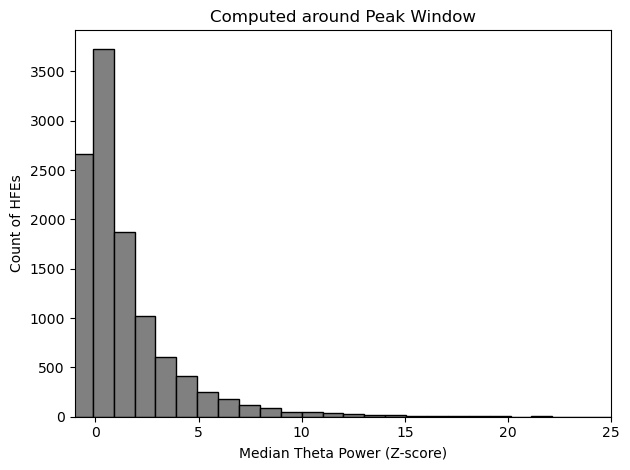

In [10]:
plt.hist(cleaned_theta_data['peakwindow_med'], bins=90, edgecolor='black', facecolor='grey')
plt.xlim(-1, 25)
plt.xlabel('Median Theta Power (Z-score)')
plt.ylabel('Count of HFEs')
plt.title('Computed around Peak Window')
plt.tight_layout()
plt.show()

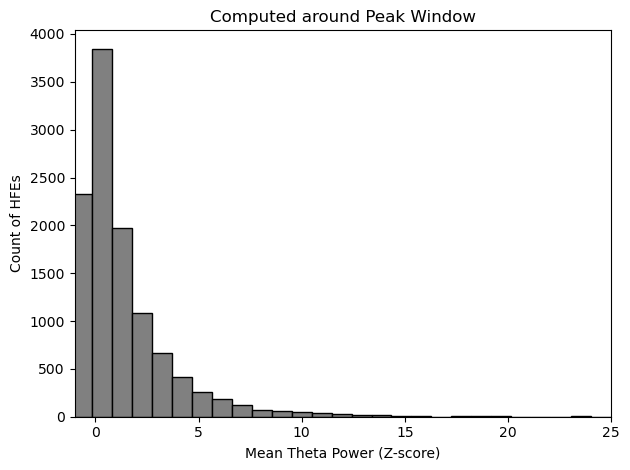

In [11]:
plt.hist(cleaned_theta_data['peakwindow_mean'], bins=90, edgecolor='black', facecolor='grey')
plt.xlim(-1, 25)
plt.xlabel('Mean Theta Power (Z-score)')
plt.ylabel('Count of HFEs')
plt.title('Computed around Peak Window')
plt.tight_layout()
plt.show()

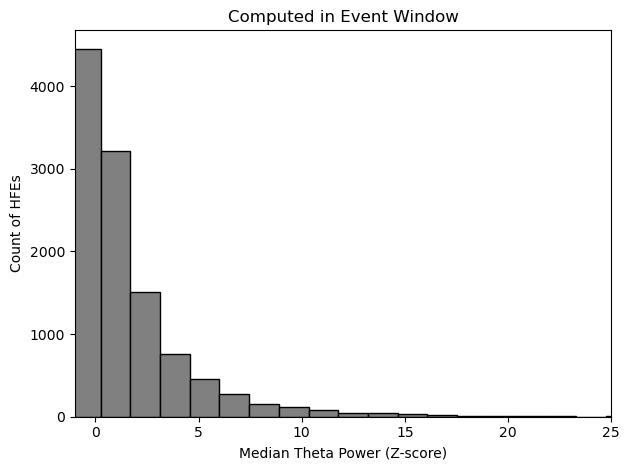

In [12]:
plt.hist(cleaned_theta_data['eventwindow_med'], bins=90, edgecolor='black', facecolor='grey')
plt.xlim(-1, 25)
plt.xlabel('Median Theta Power (Z-score)')
plt.ylabel('Count of HFEs')
plt.title('Computed in Event Window')
plt.tight_layout()
plt.show()

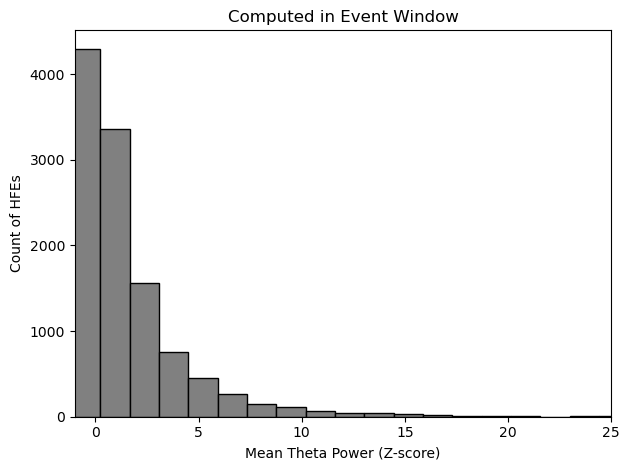

In [13]:
plt.hist(cleaned_theta_data['eventwindow_mean'], bins=90, edgecolor='black', facecolor='grey')
plt.xlim(-1, 25)
plt.xlabel('Mean Theta Power (Z-score)')
plt.ylabel('Count of HFEs')
plt.title('Computed in Event Window')
plt.tight_layout()
plt.show()

In [14]:
speed_cleaned = speeds[~np.isnan(speeds)]

In [15]:
speed_cleaned.max()

17.057541264876384

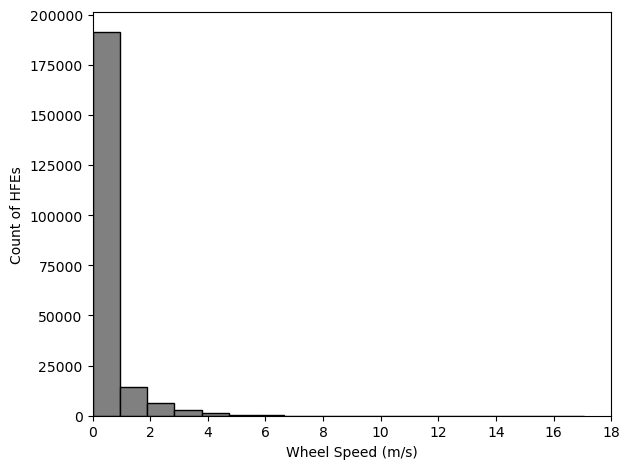

In [16]:
plt.hist(speeds, bins=18, edgecolor='black', facecolor='grey')
plt.xlim(0, 18)
plt.xlabel('Wheel Speed (m/s)')
plt.ylabel('Count of HFEs')
plt.tight_layout()
plt.show()

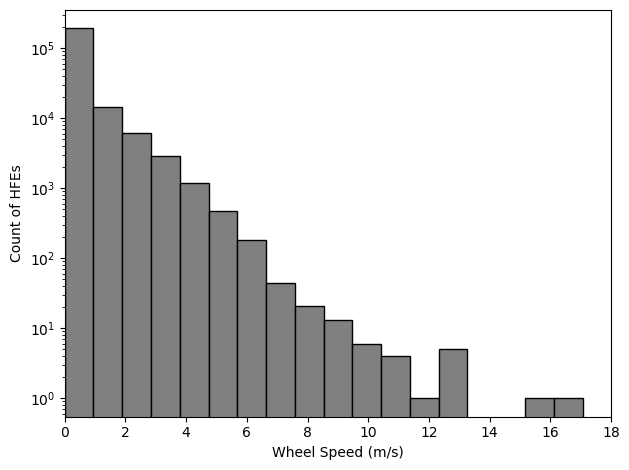

In [17]:
plt.hist(speeds, bins=18, edgecolor='black', facecolor='grey', log=True)
plt.xlim(0, 18)
plt.xlabel('Wheel Speed (m/s)')
plt.ylabel('Count of HFEs')
plt.yscale('log', base=10)
plt.tight_layout()
plt.show()

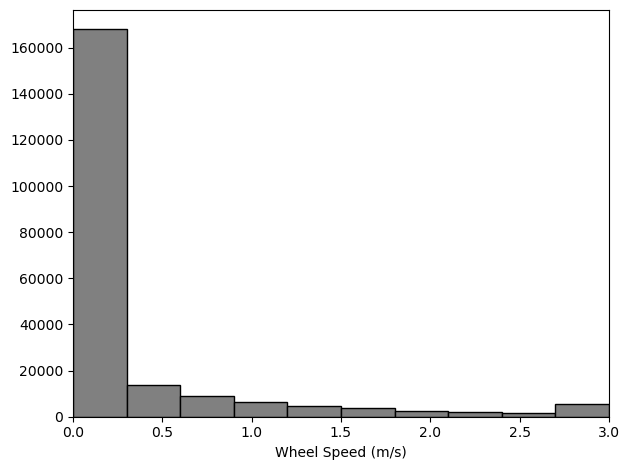

In [18]:
# Matplotlib
plt.hist(np.minimum(speeds, 3), bins=10, edgecolor='black', facecolor='grey')
plt.xlim(0, 3)
plt.xlabel('Wheel Speed (m/s)')
plt.tight_layout()
plt.show()

## Ripple Distributions

In [19]:
# getting 
directories = os.listdir(ibl_ripples_path)

processed_sesh_ids = [dir.replace('swrs_session_', '') for dir in directories if 'swrs_session_' in dir]

print(processed_sesh_ids)

['0cc486c3-8c7b-494d-aa04-b70e2690bcba', '746d1902-fa59-4cab-b0aa-013be36060d5', '6a601cc5-7b79-4c75-b0e8-552246532f82', 'edd22318-216c-44ff-bc24-49ce8be78374', '6c6983ef-7383-4989-9183-32b1a300d17a', 'd23a44ef-1402-4ed7-97f5-47e9a7a504d9', '5386aba9-9b97-4557-abcd-abc2da66b863', 'c6db3304-c906-400c-aa0f-45dd3945b2ea', 'a2701b93-d8e1-47e9-a819-f1063046f3e7', '3e6a97d3-3991-49e2-b346-6948cb4580fb', '8928f98a-b411-497e-aa4b-aa752434686d', '3638d102-e8b6-4230-8742-e548cd87a949', 'fcd49e34-f07b-441c-b2ac-cb8c462ec5ac', '0c828385-6dd6-4842-a702-c5075f5f5e81', 'b39752db-abdb-47ab-ae78-e8608bbf50ed', '1a507308-c63a-4e02-8f32-3239a07dc578', '572a95d1-39ca-42e1-8424-5c9ffcb2df87', '15b69921-d471-4ded-8814-2adad954bcd8', '02fbb6da-3034-47d6-a61b-7d06c796a830', '4b00df29-3769-43be-bb40-128b1cba6d35', 'd9f0c293-df4c-410a-846d-842e47c6b502', '9b528ad0-4599-4a55-9148-96cc1d93fb24', '6c6b0d06-6039-4525-a74b-58cfaa1d3a60', '7691eeb3-715b-4571-8fda-6bb57aab8253', 'ebe090af-5922-4fcd-8fc6-17b8ba7bad6d',

In [20]:
from fitter import Fitter, get_common_distributions, get_distributions

In [1]:
ibl_ripples_path

NameError: name 'ibl_ripples_path' is not defined

In [37]:
all_swrs_df = pd.DataFrame()
global_swr_failed_session = []
for sessionfolder in os.listdir(ibl_ripples_path):
    try:
        if 'global_swrs_no_movement_no_gamma.csv' in sessionfolder:
            continue 
        folder_path = os.path.join(ibl_ripples_path, sessionfolder)
        folderfiles = os.listdir(folder_path)
        try:
            global_ripples_filename = [file for file in folderfiles if 'global_swrs' in file][0]
            
        except:
            continue
        global_ripples_df = pd.read_csv(os.path.join(folder_path, global_ripples_filename), compression='gzip')
        global_ripples_df['duration'] = global_ripples_df['end_time'] - global_ripples_df['start_time']
        global_ripples_df['session_id'] = sessionfolder.replace('swrs_session_', '')
        all_swrs_df = pd.concat([all_swrs_df, global_ripples_df])
    except:
        global_swr_failed_session.append(sessionfolder)

In [38]:
all_swrs_df.columns

Index(['start_time', 'end_time', 'probes_event_is_on', 'events_row_index',
       'global_peak_time', 'global_max_zscore', 'peak_probe', 'duration',
       'session_id'],
      dtype='object')

,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
lognorm,9.192623,601.904927,-2.187227e+06,inf,0.020017,4.994002e-76
halfnorm,128.614855,2068.385475,-1.614169e+06,inf,0.071629,0.000000e+00
norm,202.944533,4620.325467,-1.515101e+06,inf,0.128276,0.000000e+00


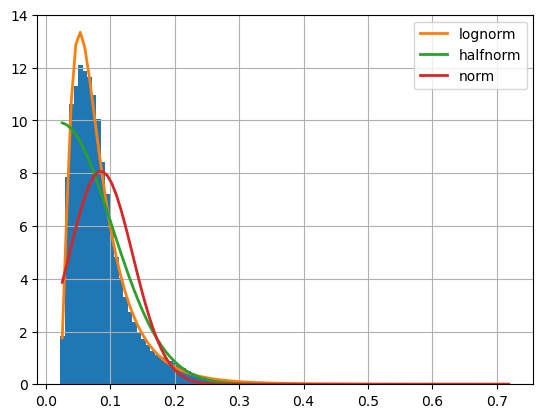

In [39]:
f_distributions = Fitter(all_swrs_df['duration'],
           distributions=['norm',
                          'lognorm',
                         'halfnorm'])
f_distributions.fit()
f_distributions.summary()

,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
lognorm,0.006026,1697.826218,-3.779317e+06,inf,0.045788,0.0
halfnorm,0.080755,5431.719238,-3.215634e+06,inf,0.224892,0.0
norm,0.133957,8147.213547,-3.105708e+06,inf,0.222171,0.0


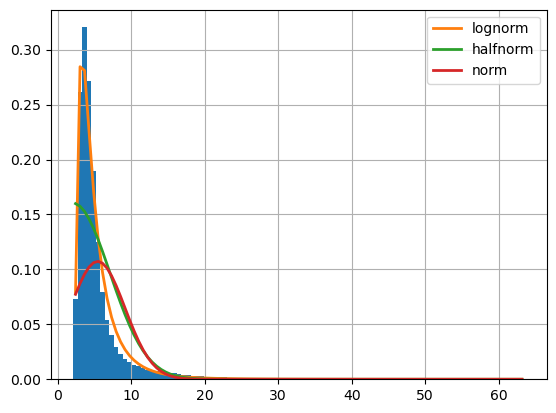

In [40]:
f_distributions = Fitter(all_swrs_df['global_max_zscore'],
           distributions=['norm',
                          'lognorm',
                         'halfnorm'])
f_distributions.fit()
f_distributions.summary()

In [41]:
global_ripples_filename

'session_6ed57216-498d-48a6-b48b-a243a34710ea_putative_global_swrs_no_movement_no_gamma.csv'

In [40]:
session_id

'6ed57216-498d-48a6-b48b-a243a34710ea'

In [34]:
global_ripples_df

,start_time,end_time,probes_event_is_on,events_row_index,global_peak_time,global_max_zscore,peak_probe,average_speed
0,0.592630,0.717297,['e31b4e39-e350-47a9-aca4-72496d99ff2a'],[0],0.644630,19.629827,e31b4e39-e350-47a9-aca4-72496d99ff2a,-0.002297
1,3.868631,3.989964,['e31b4e39-e350-47a9-aca4-72496d99ff2a'],[1],3.975964,8.561543,e31b4e39-e350-47a9-aca4-72496d99ff2a,-0.000644
2,4.277297,4.435297,['e31b4e39-e350-47a9-aca4-72496d99ff2a'],[2],4.351297,8.581667,e31b4e39-e350-47a9-aca4-72496d99ff2a,0.000039
3,12.525966,12.711966,['e31b4e39-e350-47a9-aca4-72496d99ff2a'],[3],12.604632,7.148097,e31b4e39-e350-47a9-aca4-72496d99ff2a,0.000039
4,20.220634,20.323967,['e31b4e39-e350-47a9-aca4-72496d99ff2a'],[4],20.296634,3.404769,e31b4e39-e350-47a9-aca4-72496d99ff2a,0.000039
...,...,...,...,...,...,...,...,...
763,5485.585702,5485.693035,['e31b4e39-e350-47a9-aca4-72496d99ff2a'],[793],5485.632369,2.244856,e31b4e39-e350-47a9-aca4-72496d99ff2a,-0.000926
764,5486.830369,5486.920369,['e31b4e39-e350-47a9-aca4-72496d99ff2a'],[794],5486.874369,5.542013,e31b4e39-e350-47a9-aca4-72496d99ff2a,-0.000536
765,5488.711036,5488.801036,['e31b4e39-e350-47a9-aca4-72496d99ff2a'],[795],5488.778369,3.226351,e31b4e39-e350-47a9-aca4-72496d99ff2a,-0.000533
766,5498.592371,5498.787038,['e31b4e39-e350-47a9-aca4-72496d99ff2a'],[796],5498.715705,12.394210,e31b4e39-e350-47a9-aca4-72496d99ff2a,-0.001318


In [32]:
global_ripples_df

,start_time,end_time,probes_event_is_on,events_row_index,global_peak_time,global_max_zscore,peak_probe
0,299.158686,299.198686,['db2100c3-64ac-463e-97a1-20ce8266cd5f'],[0],299.182686,2.577324,db2100c3-64ac-463e-97a1-20ce8266cd5f
1,523.814735,523.875402,['db2100c3-64ac-463e-97a1-20ce8266cd5f'],[1],523.847402,3.300278,db2100c3-64ac-463e-97a1-20ce8266cd5f
2,537.084071,537.137404,['db2100c3-64ac-463e-97a1-20ce8266cd5f'],[2],537.126738,2.886098,db2100c3-64ac-463e-97a1-20ce8266cd5f
3,913.264153,913.371486,['db2100c3-64ac-463e-97a1-20ce8266cd5f'],[3],913.305486,3.375487,db2100c3-64ac-463e-97a1-20ce8266cd5f
4,972.722166,972.766833,['db2100c3-64ac-463e-97a1-20ce8266cd5f'],[4],972.742833,2.658282,db2100c3-64ac-463e-97a1-20ce8266cd5f
...,...,...,...,...,...,...,...
239,4184.560199,4184.613533,['db2100c3-64ac-463e-97a1-20ce8266cd5f'],[254],4184.585533,2.937771,db2100c3-64ac-463e-97a1-20ce8266cd5f
240,4187.116200,4187.190200,['db2100c3-64ac-463e-97a1-20ce8266cd5f'],[255],4187.133533,4.260292,db2100c3-64ac-463e-97a1-20ce8266cd5f
241,4219.922207,4220.013540,['db2100c3-64ac-463e-97a1-20ce8266cd5f'],[256],4219.987540,4.924089,db2100c3-64ac-463e-97a1-20ce8266cd5f
242,4379.896909,4379.972909,['db2100c3-64ac-463e-97a1-20ce8266cd5f'],[257],4379.956242,3.097887,db2100c3-64ac-463e-97a1-20ce8266cd5f


In [28]:
os.listdir(os.path.join(ibl_ripples_path,sessionfolder))

['probe_db2100c3-64ac-463e-97a1-20ce8266cd5f_channel_channelsrawInd_366_karlsson_detector_events.csv',
 'probe_db2100c3-64ac-463e-97a1-20ce8266cd5f_channel_channelsrawInd_138_movement_artifacts.csv',
 'probe_db2100c3-64ac-463e-97a1-20ce8266cd5f_channel_channelsrawInd_319_movement_artifacts.csv',
 'session_0cc486c3-8c7b-494d-aa04-b70e2690bcba_putative_global_swrs_no_movement_no_gamma.csv',
 'probe_db2100c3-64ac-463e-97a1-20ce8266cd5f_channel_channelsrawInd_366_gamma_band_events.csv']

In [8]:
wheel

{'timestamps': array([   6.68261838,    7.01721591,    7.09610747, ..., 4400.2077987 ,
        4400.26992539, 4400.32881909]),
 'position': array([-1.53398079e-03, -0.00000000e+00, -1.53398079e-03, ...,
        -1.30568610e+03, -1.30568763e+03, -1.30568917e+03])}

In [9]:
try:
    # Warning: Some older sessions may not have a wheelMoves dataset
    wheel_moves = one.load_object(session_id, 'wheelMoves', collection='alf')
except AssertionError:
    wheel_moves = extract_wheel_moves(wheel.timestamps, wheel.position)

In [10]:
wheel_moves.keys()

dict_keys(['intervals', 'peakAmplitude'])

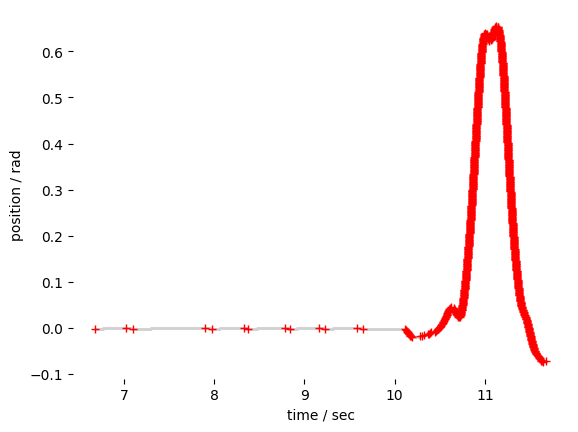

In [11]:
pos, t = wh.interpolate_position(wheel.timestamps, wheel.position)
sec = 5  # Number of seconds to plot
plt.figure()

# Plot the interpolated data points
mask = t < (t[0] + sec)
plt.plot(t[mask], pos[mask], '.', markeredgecolor='lightgrey', markersize=1)

# Plot the original data
mask = wheel.timestamps < (wheel.timestamps[0] + sec)
plt.plot(wheel.timestamps[mask], wheel.position[mask], 'r+', markersize=6)

# Labels etc.
plt.xlabel('time / sec')
plt.ylabel('position / rad')
plt.box(on=None)
plt.show()

In [12]:
# Convert the pos threshold defaults from samples to correct unit
thresholds_cm = wh.samples_to_cm(np.array([8, 1.5]), resolution=wh.ENC_RES)
thresholds = wh.cm_to_rad(thresholds_cm)

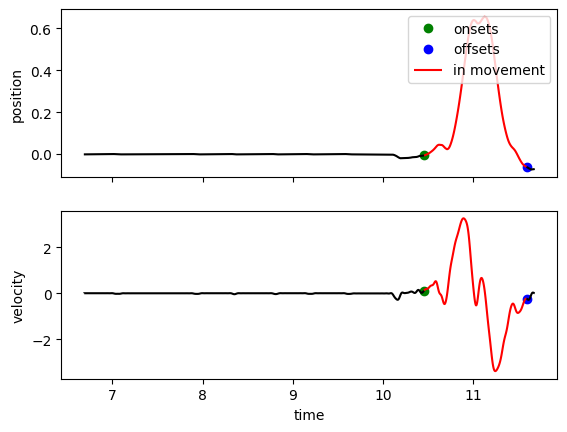

In [13]:
# Detect wheel movements for the first 5 seconds
mask = t < (t[0] + sec)

onsets, offsets, peak_amp, peak_vel_times = wh.movements(
    t[mask], pos[mask], pos_thresh=thresholds[0], pos_thresh_onset=thresholds[0], make_plots=True)
plt.show()

In [14]:
pos.shape

(4393647,)

In [17]:
pos[pos.shape[0]-1]

-1305.689159862322

In [21]:
test = np.array([t[i]-t[i-1] for i in range(1,t.shape[0]) ])
1/test.mean()

999.9999999996661

In [22]:
delta_t = 1/np.array([t[i]-t[i-1] for i in range(1,t.shape[0]) ]).mean()
delta_t

999.9999999996661

In [23]:
delta_t = 1/np.array([t[i]-t[i-1] for i in range(1,t.shape[0]) ]).mean()
testvel, testaccel = wh.velocity_filtered(pos, delta_t)

In [25]:
testvel

array([ 0.        ,  0.00494591,  0.00492749, ..., -0.00218496,
       -0.00181555, -0.00149305])